In [1]:
from sklearn.model_selection import cross_val_score, GroupKFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
import shap
import pickle
import matplotlib.image as mpimg
from PIL import Image
import matplotlib.colors as mcolors
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

# Data For

In [2]:
#data_for = '_PredMP'

#data_for = '_ExpMP'

data_for = '_NoMP'

In [3]:
black = '#515265'
red = '#DD706E'
yellow = '#FAAF3A'
blue = '#3A93C2'

In [4]:
file_path = '../../Exp_2_Dataset_feature_engineering/Summary_and_dataset/refined_dataset' + data_for + '.csv'

data = pd.read_csv(file_path)
train = data[data['Type'] == 'Train']
test = data[data['Type'] == 'Test']
lab = data[data['Type'] == 'Lab']

In [5]:
overlapping_values = set(train['Drug-solvent system']).intersection(test['Drug-solvent system'])
overlapping_values

set()

In [6]:
def data_processing (dataset):

    X = dataset.drop(['Type', 'Drug', 'Solvent_1', 'Solvent_2', 'Drug-solvent system', 'LogS', 'Class', 'Solubility (g/100g)'], axis = 1)
    Y = dataset['LogS']
    G = dataset['Drug-solvent system']

    return X, Y, G

In [7]:
X_train, Y_train, G_train = data_processing(train)
X_test, Y_test, G_test = data_processing(test)
X_lab, Y_lab, G_lab = data_processing(lab)

# Hyperparameter screening

In [9]:
search_spaces = {
    "DT": {
        "max_depth": Integer(3, 20),
        "splitter":Categorical(['best', 'random']),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
    },
    "RF": {
        "n_estimators": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "min_samples_split": Real(0.01, 0.1),
        "min_samples_leaf": Integer(1, 20),
        "max_features": Categorical(['auto', 'sqrt', 'log2']),
        "bootstrap": Categorical([True, False]),
    },
    "XGB": {
        "n_estimators": Integer(10, 400),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "max_depth": Integer(3, 20),
        "subsample": Real(0.5, 1.0),
        "colsample_bytree": Real(0.5, 1.0),
        "gamma": Real(0, 5),
    },
    "NN": {
        "hidden_layer_sizes": Integer(2, 64),
        "alpha": Real(0.0001, 0.1, prior="log-uniform"),
        "learning_rate_init": Real(0.001, 0.1, prior="log-uniform"),
        "activation": Categorical(['relu', 'tanh', 'logistic']),
},

    "LightGBM": {
        "num_leaves": Integer(10, 400),
        "max_depth": Integer(3, 20),
        "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
        "n_estimators": Integer(100, 1000),
        "bagging_fraction": Real(0.5, 1),
        "feature_fraction": Real(0.5, 1),
        "min_child_samples": Integer(5, 100),
    },
    "MLR": {
        'fit_intercept':Categorical([True, False]),
        'positive':Categorical([True, False])
    },
    "Lasso": {
        "alpha": Real(0.0001, 1, prior="log-uniform"),
        "selection": Categorical(['cyclic', 'random']),
    },
    "kNN": {'n_neighbors':Integer(2, 50),
            'weights': Categorical(["uniform", 'distance']),
            'algorithm': Categorical(['auto', 'ball_tree', 'kd_tree', 'brute']),
            'leaf_size': Integer(10, 100),
            'p':Integer(1, 2),
    },
    "PLS": {'n_components':Integer(2, 6),
            'max_iter': Integer(250, 1000)
    }
    
}


In [10]:
search_spaces_df = pd.DataFrame([(model, params) for model, params in search_spaces.items()], columns=['Model', 'Hyperparameters'])

search_spaces_df.to_excel('Table_SI_search_space.xlsx', index = False)

In [11]:
models = {
    "DT": DecisionTreeRegressor(random_state=0),
    "RF": RandomForestRegressor(random_state=0, n_jobs=6),
    "XGB": XGBRegressor(random_state=0, n_jobs=6),
    "NN": MLPRegressor(random_state=0),
    "LightGBM": lgb.LGBMRegressor(random_state=0, n_jobs=6),
    "MLR": LinearRegression(),
    "Lasso": Lasso(),
    "PLS": PLSRegression(),
    "kNN": KNeighborsRegressor(n_jobs=6)}

In [12]:
def perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter):

    
    model = models[model_name]
    search_space = search_spaces[model_name]
    
    
    cv = GroupKFold(n_splits=10)

    
    bscv = BayesSearchCV(
        estimator=model,
        search_spaces=search_space,
        scoring='neg_mean_absolute_error',
        cv=cv,
        n_iter=n_iter,
        n_jobs=6,
        verbose=0,
        random_state = 0
    )

    
    bscv.fit(X_train, Y_train, groups=G_train)
    optimization_history = bscv.cv_results_


    
    return bscv.best_estimator_, bscv.best_params_, bscv.best_score_, optimization_history


In [13]:
#model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]

model_names = ["LightGBM", "XGB"]


n_iter = 100



In [14]:
#model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]

model_names = ["DT", "RF", "NN", "MLR", "Lasso", "PLS", "kNN"]


results = {}

n_iter = 100


In [15]:
for model_name in model_names:
    result = {}

    start = time.time()
    search_space = search_spaces[model_name]
    best_model, best_params, best_score, history = perform_hp_screening(model_name, X_train, Y_train, G_train, n_iter)
    end = time.time()
    
    print()
    print(model_name, ':  ', round(best_score,3))
    print(round((end-start)/60, 1), 'min')
    print()
    
    # Storing the results in a dictionary
    result[model_name] = {
        'best_estimator': best_model,
        'best_params': best_params,
        'best_score': best_score,
        'optimization_history': history
    }

    pickle_file_path = 'Results/' + model_name + '_BSCV_results' + data_for + '.pkl'

    with open(pickle_file_path, 'wb') as handle:
        pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: Fu

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated 


DT :   -0.443
3.4 min



/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitl

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will b


RF :   -0.396
205.0 min



The objective has been evaluated at this point before.
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.



NN :   -0.374
36.0 min



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this poi


MLR :   -42590838138.762
12.1 min



/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e+01, tolerance: 1.893e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e+01, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e+01, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.213e+01, tolerance: 1.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.872e+00, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.563e+00, tolerance: 2.010e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.330e+02, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e+02, tolerance: 1.953e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e+01, tolerance: 1.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e+01, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.034e+01, tolerance: 1.893e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.789e+01, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.381e+00, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e+01, tolerance: 1.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e+01, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.495e+01, tolerance: 1.953e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.540e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+01, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e+02, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e+02, tolerance: 1.953e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.658e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.141e+00, tolerance: 1.900e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.907e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.337e+00, tolerance: 1.910e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e+02, tolerance: 1.953e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.766e+02, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e+00, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e+00, tolerance: 1.900e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.849e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.727e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.536e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.814e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.408e+01, tolerance: 2.010e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.018e+01, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.528e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.805e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.866e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.741e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.438e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.476e+00, tolerance: 1.893e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.703e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.901e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.980e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.692e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.723e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.613e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.672e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.965e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.034e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.304e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.820e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.956e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.035e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.661e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.912e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.006e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.164e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.541e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.730e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.182e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.485e+00, tolerance: 1.820e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.775e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec

/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.491e+00, tolerance: 1.946e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.648e+00, tolerance: 1.959e+00
  model = cd_fast.enet_coordinate_descent(
/Users/shichenma/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, chec


Lasso :   -0.43
19.0 min



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object


PLS :   -0.523
2.7 min



The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The object


kNN :   -0.348
22.9 min



In [8]:
model_names = ["DT", "RF", "XGB",  "NN", "LightGBM", "MLR", "Lasso", "PLS", "kNN"]

In [11]:
results = {}

for model_name in model_names:

    pickle_file_path = 'Results/' + model_name + '_BSCV_results' + data_for + '.pkl'
    
    with open(pickle_file_path, 'rb') as handle:
        result = pickle.load(handle)
        
    results[model_name] = {
        'best_estimator': result[model_name]['best_estimator'],
        'best_params': result[model_name]['best_params'],
        'best_score': result[model_name]['best_score'],
        'optimization_history': result[model_name]['optimization_history']
    }

Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator MLPRegressor from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator LinearRegression from version 1.1.3 when using version 1.1.2. This might lead to breaking code or 

In [12]:
combined_pickle_file_path = 'Results/BSCV_results' + data_for + '.pkl'

In [13]:


with open(combined_pickle_file_path, 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:

with open(combined_pickle_file_path, 'rb') as handle:
    results = pickle.load(handle)

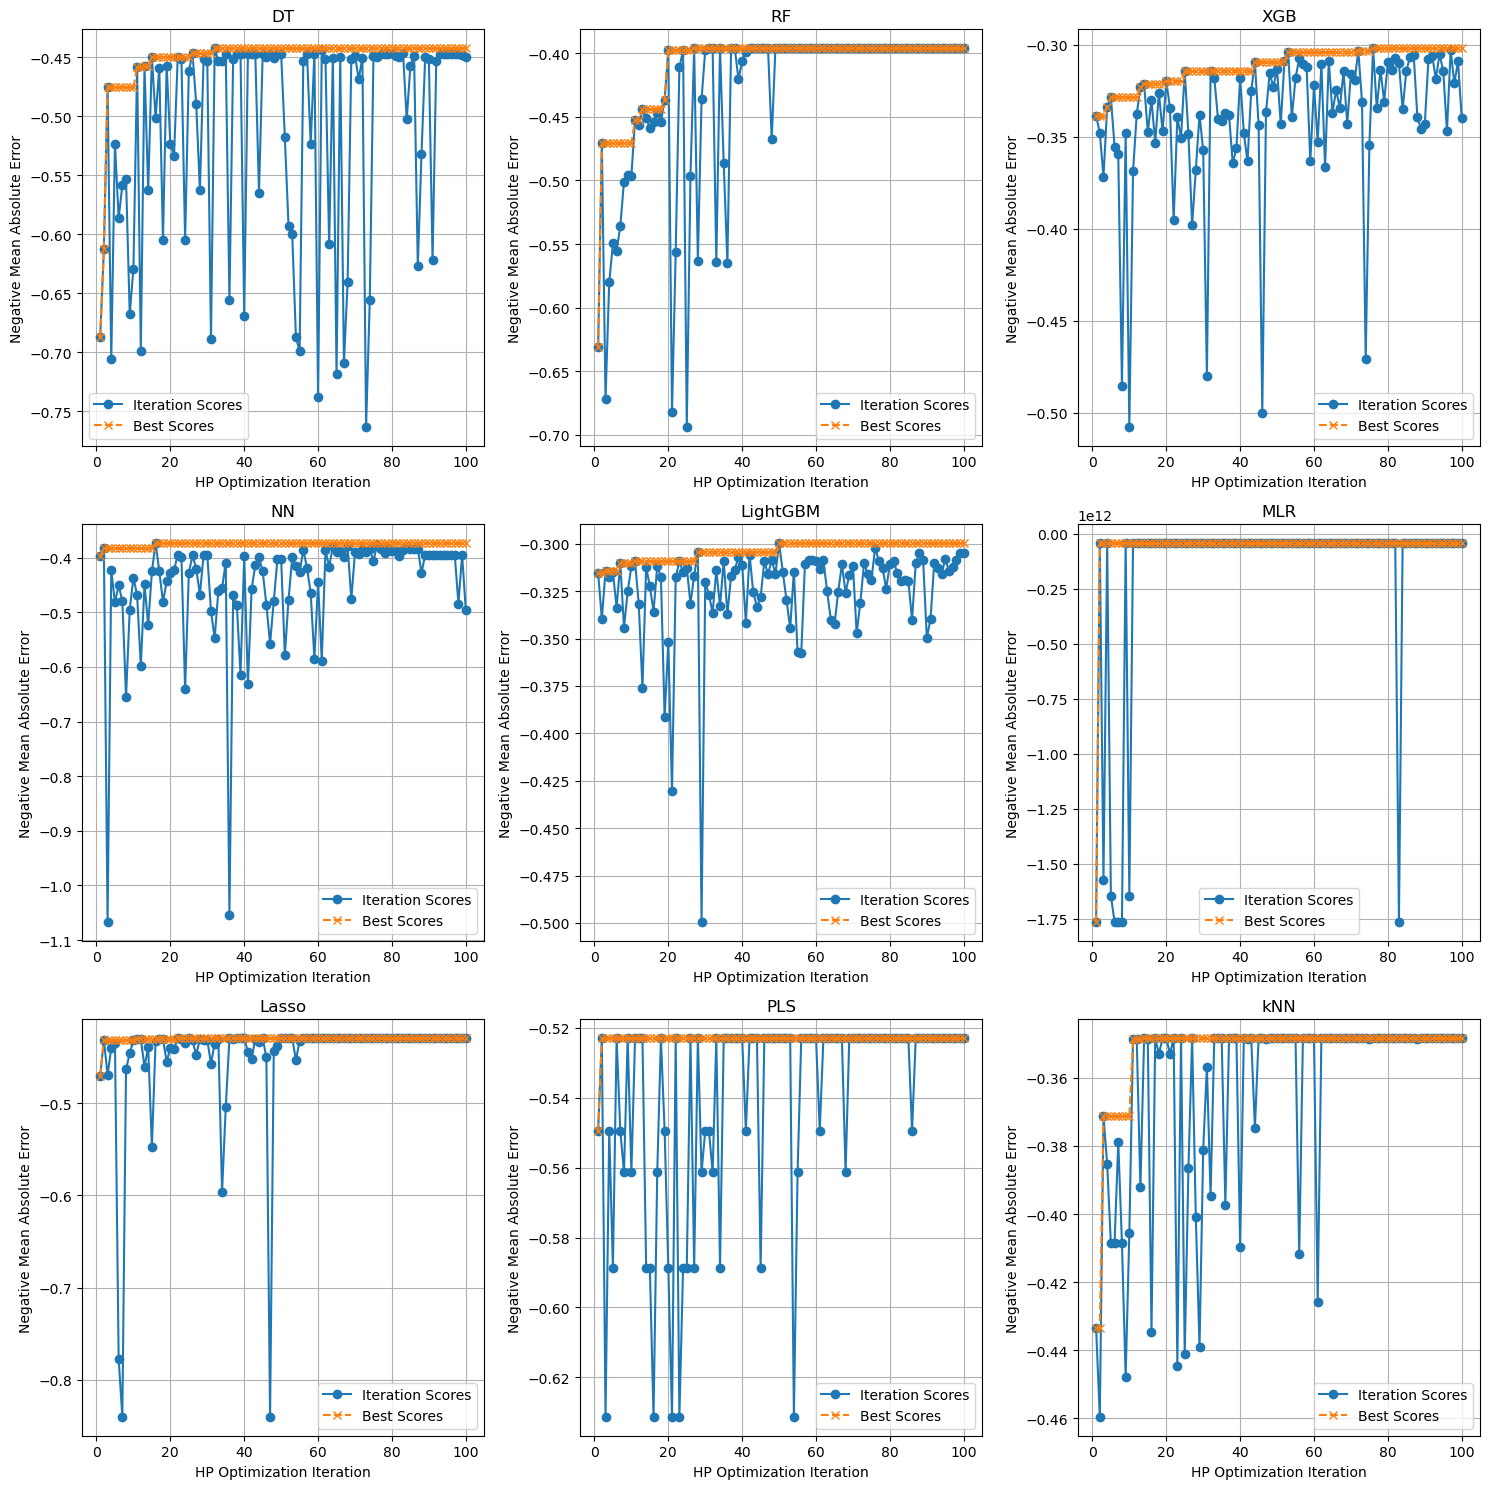

In [15]:

fig, axs = plt.subplots(3, 3, figsize=(15, 15))


for idx, model_name in enumerate(model_names):
    optimization_history = results[model_name]['optimization_history']

    scores = optimization_history['mean_test_score']
    iterations = range(1, len(scores) + 1)

    best_scores = np.maximum.accumulate(scores)

    ax = axs[idx // 3, idx % 3] 
    ax.plot(iterations, scores, marker='o', label='Iteration Scores')
    ax.plot(iterations, best_scores, marker='x', linestyle='--', label='Best Scores')
    ax.set_xlabel('HP Optimization Iteration')
    ax.set_ylabel('Negative Mean Absolute Error')
    ax.set_title(model_name)
    ax.legend()
    ax.grid(True)

plt.tight_layout()


fig.savefig('Optimization_history' + data_for + '.png', dpi=300, format='png', transparent=True)

plt.show()

In [16]:
optimized_HP_df = pd.DataFrame([(model, best_params) for model, best_params in results.items()], columns=['Model', 'Best Hyperparameter'])
optimized_HP_df.to_excel('Table_SI_optimized_HP' + data_for + '.xlsx', index = False)




# Model evaluation using the literature test set

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = ['MAE', 'MedAE', 'RMSE', 'MSE', 'PCC', 'SCC']
train_summary = pd.DataFrame(index=metrics, columns=model_names)
test_summary = pd.DataFrame(index=metrics, columns=model_names)
predictions = pd.DataFrame(columns=model_names)

for model_name in model_names:
    model = results[model_name]['best_estimator']

    cv = GroupKFold(n_splits=10)
    Y_pred_train = cross_val_predict(model, X_train, Y_train, cv=cv, groups=G_train, n_jobs=6)

    Y_train = np.ravel(Y_train)
    Y_pred_train = np.ravel(Y_pred_train)
    
    train_summary[model_name]['MAE'] = mean_absolute_error(Y_train, Y_pred_train)
    train_summary[model_name]['MedAE'] = np.median(abs(Y_train - Y_pred_train))
    train_summary[model_name]['RMSE'] = rmse(Y_train, Y_pred_train)
    train_summary[model_name]['MSE'] = mean_squared_error(Y_train, Y_pred_train)
    train_summary[model_name]['PCC'] = pearsonr(Y_train, Y_pred_train)[0]
    train_summary[model_name]['SCC'] = spearmanr(Y_train, Y_pred_train)[0]



    model.fit(X_train, Y_train)
    Y_pred_test = model.predict(X_test)
    
    Y_pred_test = np.ravel(Y_pred_test)
    
    test_summary[model_name]['MAE'] = mean_absolute_error(Y_test, Y_pred_test)
    test_summary[model_name]['MedAE'] = np.median(abs(Y_test - Y_pred_test))
    test_summary[model_name]['RMSE'] = rmse(Y_test, Y_pred_test)
    test_summary[model_name]['MSE'] = mean_squared_error(Y_test, Y_pred_test)
    test_summary[model_name]['PCC'] = pearsonr(Y_test, Y_pred_test)[0]
    test_summary[model_name]['SCC'] = spearmanr(Y_test, Y_pred_test)[0]
    
    predictions[model_name] = Y_pred_test

/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/tree/_classes.py:306: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and w

[LightGBM] [Warning] feature_fraction is set=0.5718327416298681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5718327416298681
[LightGBM] [Warning] bagging_fraction is set=0.6267043739455292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6267043739455292
[LightGBM] [Warning] feature_fraction is set=0.5718327416298681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5718327416298681
[LightGBM] [Warning] bagging_fraction is set=0.6267043739455292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6267043739455292
[LightGBM] [Warning] feature_fraction is set=0.5718327416298681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5718327416298681
[LightGBM] [Warning] bagging_fraction is set=0.6267043739455292, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6267043739455292
[LightGBM] [Warning] feature_fraction is set=0.5718327416298681, colsample_bytree=1.0 will be ign

/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.891e+00, tolerance: 1.909e+00
  model = cd_fast.enet_coordinate_descent(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e+00, tolerance: 1.917e+00
  model = cd_fast.enet_coordinate_descent(
/Users/zeqing/opt/anaconda3/envs/Solubility/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

In [18]:
train_summary

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.442559,0.396292,0.301996,0.373633,0.299724,42616905966.272728,0.429592,0.522973,0.348412
MedAE,0.323426,0.30273,0.21616,0.268835,0.204516,0.474461,0.323974,0.410431,0.201953
RMSE,0.610337,0.537276,0.424618,0.534787,0.424466,376096287110.751038,0.591977,0.685566,0.545886
MSE,0.372511,0.288666,0.1803,0.285997,0.180172,141448417178492457713664.0,0.350436,0.470001,0.297992
PCC,0.818947,0.855076,0.913746,0.860518,0.91312,-0.056984,0.825876,0.759759,0.86034
SCC,0.798264,0.845113,0.899522,0.847832,0.90097,0.578319,0.810585,0.728301,0.842392


In [19]:
test_summary

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.533542,0.455522,0.333548,0.386289,0.316392,18647812177.196281,0.496705,0.504657,0.419617
MedAE,0.312662,0.290952,0.222298,0.22477,0.200616,0.509557,0.340378,0.385542,0.261482
RMSE,0.838699,0.669517,0.490679,0.597298,0.481341,98009720760.639008,0.737557,0.691804,0.649461
MSE,0.703416,0.448253,0.240766,0.356765,0.231689,9605905363578432520192.0,0.54399,0.478593,0.4218
PCC,0.68731,0.790779,0.892577,0.839327,0.8957,0.050118,0.753443,0.765363,0.819873
SCC,0.662602,0.752914,0.867726,0.796649,0.868613,0.510265,0.722152,0.74795,0.781045


In [20]:
test_AE = predictions.copy()

test_AE['Y'] = Y_test.values

for model_name in model_names:
    test_AE[model_name] = abs(test_AE[model_name] - test_AE['Y'])
    
test_AE = test_AE.drop(['Y'], axis = 1)    
test_AE

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
0,0.245396,0.013138,0.137280,0.097673,0.060887,0.279407,0.213956,0.269739,0.748986
1,1.115786,0.566861,0.147877,0.227330,0.118547,0.419626,0.479597,0.441253,0.309704
2,0.216673,0.697152,0.512907,0.199906,0.415820,0.524552,0.445325,0.576321,0.992895
3,0.285437,0.765916,0.554940,0.234634,0.446686,0.472711,0.391403,0.536842,0.983542
4,0.069419,0.475763,0.390742,0.230473,0.364223,0.581172,0.512908,0.609024,1.019274
...,...,...,...,...,...,...,...,...,...
6805,0.122798,0.072120,0.019472,0.173583,0.019580,0.115470,0.676444,0.560974,0.087101
6806,0.030020,0.045196,0.038749,0.010831,0.040954,0.147682,0.706576,0.605549,0.125998
6807,0.076228,0.149642,0.047734,0.185369,0.073477,0.132615,0.689427,0.602843,0.133551
6808,0.294994,0.266175,0.166549,0.229973,0.226932,0.218008,0.347067,0.202711,0.125740


In [21]:
for column in train_summary.columns:
    train_summary[column] = train_summary[column].astype(float)
    test_summary[column] = test_summary[column].astype(float)

In [26]:
train_summary_round = train_summary.round(2)
test_summary_round = test_summary.round(2)

In [27]:
train_summary_round

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.44,0.40,0.30,0.37,0.30,4.261691e+10,0.43,0.52,0.35
MedAE,0.32,0.30,0.22,0.27,0.20,4.700000e-01,0.32,0.41,0.20
RMSE,0.61,0.54,0.42,0.53,0.42,3.760963e+11,0.59,0.69,0.55
MSE,0.37,0.29,0.18,0.29,0.18,1.414484e+23,0.35,0.47,0.30
PCC,0.82,0.86,0.91,0.86,0.91,-6.000000e-02,0.83,0.76,0.86
SCC,0.80,0.85,0.90,0.85,0.90,5.800000e-01,0.81,0.73,0.84


In [28]:
test_summary_round

,DT,RF,XGB,NN,LightGBM,MLR,Lasso,PLS,kNN
MAE,0.53,0.46,0.33,0.39,0.32,1.864781e+10,0.50,0.50,0.42
MedAE,0.31,0.29,0.22,0.22,0.20,5.100000e-01,0.34,0.39,0.26
RMSE,0.84,0.67,0.49,0.60,0.48,9.800972e+10,0.74,0.69,0.65
MSE,0.70,0.45,0.24,0.36,0.23,9.605905e+21,0.54,0.48,0.42
PCC,0.69,0.79,0.89,0.84,0.90,5.000000e-02,0.75,0.77,0.82
SCC,0.66,0.75,0.87,0.80,0.87,5.100000e-01,0.72,0.75,0.78


In [29]:
test_summary_round_T = test_summary_round.T
test_summary_round_T

,MAE,MedAE,RMSE,MSE,PCC,SCC
DT,5.300000e-01,0.31,8.400000e-01,7.000000e-01,0.69,0.66
RF,4.600000e-01,0.29,6.700000e-01,4.500000e-01,0.79,0.75
XGB,3.300000e-01,0.22,4.900000e-01,2.400000e-01,0.89,0.87
NN,3.900000e-01,0.22,6.000000e-01,3.600000e-01,0.84,0.80
LightGBM,3.200000e-01,0.20,4.800000e-01,2.300000e-01,0.90,0.87
MLR,1.864781e+10,0.51,9.800972e+10,9.605905e+21,0.05,0.51
Lasso,5.000000e-01,0.34,7.400000e-01,5.400000e-01,0.75,0.72
PLS,5.000000e-01,0.39,6.900000e-01,4.800000e-01,0.77,0.75
kNN,4.200000e-01,0.26,6.500000e-01,4.200000e-01,0.82,0.78


In [30]:
sorted_models_ind = test_summary_round_T.sort_values(by="MAE", ascending=True).index
sorted_models = test_summary_round_T.loc[sorted_models_ind]
sorted_models



,MAE,MedAE,RMSE,MSE,PCC,SCC
LightGBM,3.200000e-01,0.20,4.800000e-01,2.300000e-01,0.90,0.87
XGB,3.300000e-01,0.22,4.900000e-01,2.400000e-01,0.89,0.87
NN,3.900000e-01,0.22,6.000000e-01,3.600000e-01,0.84,0.80
kNN,4.200000e-01,0.26,6.500000e-01,4.200000e-01,0.82,0.78
RF,4.600000e-01,0.29,6.700000e-01,4.500000e-01,0.79,0.75
Lasso,5.000000e-01,0.34,7.400000e-01,5.400000e-01,0.75,0.72
PLS,5.000000e-01,0.39,6.900000e-01,4.800000e-01,0.77,0.75
DT,5.300000e-01,0.31,8.400000e-01,7.000000e-01,0.69,0.66
MLR,1.864781e+10,0.51,9.800972e+10,9.605905e+21,0.05,0.51


In [31]:
test_AE = test_AE[sorted_models_ind]
test_AE

,LightGBM,XGB,NN,kNN,RF,Lasso,PLS,DT,MLR
0,0.060887,0.137280,0.097673,0.748986,0.013138,0.213956,0.269739,0.245396,0.279407
1,0.118547,0.147877,0.227330,0.309704,0.566861,0.479597,0.441253,1.115786,0.419626
2,0.415820,0.512907,0.199906,0.992895,0.697152,0.445325,0.576321,0.216673,0.524552
3,0.446686,0.554940,0.234634,0.983542,0.765916,0.391403,0.536842,0.285437,0.472711
4,0.364223,0.390742,0.230473,1.019274,0.475763,0.512908,0.609024,0.069419,0.581172
...,...,...,...,...,...,...,...,...,...
6805,0.019580,0.019472,0.173583,0.087101,0.072120,0.676444,0.560974,0.122798,0.115470
6806,0.040954,0.038749,0.010831,0.125998,0.045196,0.706576,0.605549,0.030020,0.147682
6807,0.073477,0.047734,0.185369,0.133551,0.149642,0.689427,0.602843,0.076228,0.132615
6808,0.226932,0.166549,0.229973,0.125740,0.266175,0.347067,0.202711,0.294994,0.218008


In [32]:
test_summary_round = test_summary_round[sorted_models_ind]
test_summary_round.to_excel('Figure_3b' + data_for + '.xlsx', index = True)
test_summary_round

,LightGBM,XGB,NN,kNN,RF,Lasso,PLS,DT,MLR
MAE,0.32,0.33,0.39,0.42,0.46,0.50,0.50,0.53,1.864781e+10
MedAE,0.20,0.22,0.22,0.26,0.29,0.34,0.39,0.31,5.100000e-01
RMSE,0.48,0.49,0.60,0.65,0.67,0.74,0.69,0.84,9.800972e+10
MSE,0.23,0.24,0.36,0.42,0.45,0.54,0.48,0.70,9.605905e+21
PCC,0.90,0.89,0.84,0.82,0.79,0.75,0.77,0.69,5.000000e-02
SCC,0.87,0.87,0.80,0.78,0.75,0.72,0.75,0.66,5.100000e-01


In [33]:
train_summary_round = train_summary_round[sorted_models_ind]
train_summary_round.to_excel('Figure_SI_training_results' + data_for + '.xlsx', index = True)
train_summary_round

,LightGBM,XGB,NN,kNN,RF,Lasso,PLS,DT,MLR
MAE,0.30,0.30,0.37,0.35,0.40,0.43,0.52,0.44,4.261691e+10
MedAE,0.20,0.22,0.27,0.20,0.30,0.32,0.41,0.32,4.700000e-01
RMSE,0.42,0.42,0.53,0.55,0.54,0.59,0.69,0.61,3.760963e+11
MSE,0.18,0.18,0.29,0.30,0.29,0.35,0.47,0.37,1.414484e+23
PCC,0.91,0.91,0.86,0.86,0.86,0.83,0.76,0.82,-6.000000e-02
SCC,0.90,0.90,0.85,0.84,0.85,0.81,0.73,0.80,5.800000e-01


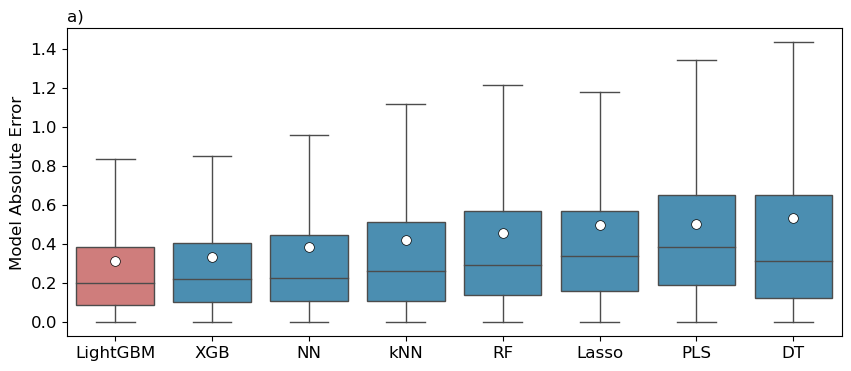

In [34]:

plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})


palette = [red] + [blue] * (len(test_AE.columns) - 1)


sns.boxplot(data=test_AE.drop(['MLR'], axis=1), palette=palette, showfliers=False, showmeans=True,linewidth = 1.0, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize": 7, "markeredgewidth": 0.5, "markeredgecolor": "black"})

        
plt.title('')
plt.ylabel('Model Absolute Error')

plt.annotate('a)', xy=(0, 1.06), xycoords="axes fraction", va="top", ha="left", fontsize=12)
plt.savefig('Figure_3a_Model_test_boxplots' + data_for + '.png', transparent=True, dpi=300)

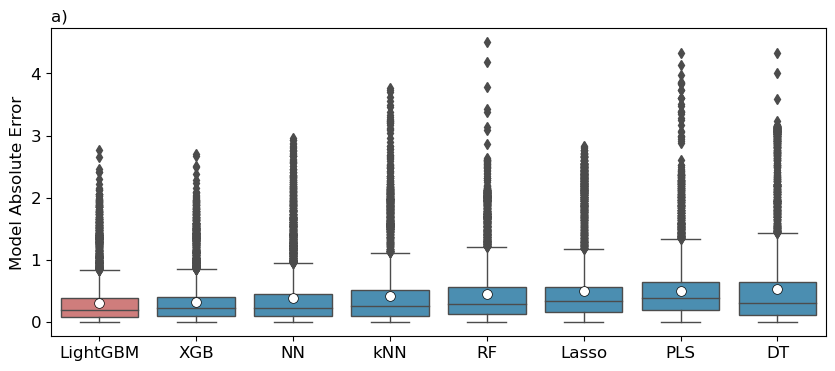

In [35]:

plt.figure(figsize=(10, 4))
plt.rcParams.update({'font.size': 12})


palette = [red] + [blue] * (len(test_AE.columns) - 1)


sns.boxplot(data=test_AE.drop(['MLR'], axis=1), palette=palette, showfliers=True, showmeans=True,linewidth = 1.0, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"white", "markersize": 7, "markeredgewidth": 0.5, "markeredgecolor": "black"})


        
plt.title('')
plt.ylabel('Model Absolute Error')

plt.annotate('a)', xy=(0, 1.06), xycoords="axes fraction", va="top", ha="left", fontsize=12)
plt.savefig('Figure_SI_model_test_boxplots_with_outliers' + data_for + '.png', transparent=True, dpi=300)